## Цели исследования

### Постановка задачи

Задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;m
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats as st
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from scipy import stats
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
marketing_events = pd.read_csv('/Users/linahazieva/Desktop/Проекты/ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt']) # календарь маркетинговых событий на 2020 год
ab_new_users = pd.read_csv('/Users/linahazieva/Desktop/Проекты/final_ab_new_users.csv', parse_dates=['first_date']) # пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
ab_events = pd.read_csv('/Users/linahazieva/Desktop/Проекты/final_ab_events.csv', parse_dates=['event_dt']) # действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
ab_participants = pd.read_csv('/Users/linahazieva/Desktop/Проекты/final_ab_participants.csv') # таблица участников тестов

In [3]:
data_list = [marketing_events, ab_new_users, ab_events, ab_participants]
pd.set_option('display.max_colwidth', 500)

for df in data_list:
    display(df.head(), df.info(), df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  14 non-null     int64         
 1   name        14 non-null     object        
 2   regions     14 non-null     object        
 3   start_dt    14 non-null     datetime64[ns]
 4   finish_dt   14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 688.0+ bytes


,Unnamed: 0,name,regions,start_dt,finish_dt
0,0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4,4th of July Promo,N.America,2020-07-04,2020-07-11


None

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  61733 non-null  int64         
 1   user_id     61733 non-null  object        
 2   first_date  61733 non-null  datetime64[ns]
 3   region      61733 non-null  object        
 4   device      61733 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.4+ MB


,Unnamed: 0,user_id,first_date,region,device
0,0,D72A72121175D8BE,2020-12-07,EU,PC
1,1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,3,50734A22C0C63768,2020-12-07,EU,iPhone
4,4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


None

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Unnamed: 0  440317 non-null  int64         
 1   user_id     440317 non-null  object        
 2   event_dt    440317 non-null  datetime64[ns]
 3   event_name  440317 non-null  object        
 4   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 16.8+ MB


,Unnamed: 0,user_id,event_dt,event_name,details
0,0,E1BDDCE0DAFA2679,2020-12-07,purchase,99.99
1,1,7B6452F081F49504,2020-12-07,purchase,9.99
2,2,9CD9F34546DF254C,2020-12-07,purchase,4.99
3,3,96F27A054B191457,2020-12-07,purchase,4.99
4,4,1FD7660FDF94CA1F,2020-12-07,purchase,4.99


None

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18268 non-null  int64 
 1   user_id     18268 non-null  object
 2   group       18268 non-null  object
 3   ab_test     18268 non-null  object
dtypes: int64(1), object(3)
memory usage: 571.0+ KB


,Unnamed: 0,user_id,group,ab_test
0,0,D1ABA3E2887B6A73,A,recommender_system_test
1,1,A7A3664BD6242119,A,recommender_system_test
2,2,DABC14FDDFADD29E,A,recommender_system_test
3,3,04988C5DF189632E,A,recommender_system_test
4,4,482F14783456D21B,B,recommender_system_test


None

0

In [4]:
# для удобства оставим только дату в ab_events
ab_events['event_dt'] = ab_events['event_dt'].dt.date

In [5]:
ab_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [6]:
ab_events[ab_events['details'].isna()]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

In [7]:
ab_events[ab_events['details'].isna() == False]['event_name'].unique()

array(['purchase'], dtype=object)

Пропуски столбце details означают, что дополнительных данных для события нет. Дополнительные данные есть только для  purchase, в details для purchase хранится стоимость покупки в долларах.

Все типы кроме корректны.

## Оценка корректности теста

### Соответствие данных требованиям технического задания

In [8]:
# посмотрим, данные за какой период представлены в таблице ab_events
ab_events['event_dt'].min(), ab_events['event_dt'].max()

(datetime.date(2020, 12, 7), datetime.date(2020, 12, 30))

По ТЗ нам для теста необходимы действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года, а мы имеем только с 7 по 30 декабря 2020 года.

In [9]:
# посмотрим, данные за какой период представлены в таблице ab_new_users
ab_new_users['first_date'].min(), ab_new_users['first_date'].max()

(Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-23 00:00:00'))

По ТЗ дата остановки набора новых пользователей 2020-12-21, значит, в наши данные попали лишние регистрации.

In [10]:
# удалим из данных лишние регистрации
ab_new_users_1 = ab_new_users[ab_new_users['first_date'] <= '2020-12-21 00:00:00']
ab_new_users_1.head()

,Unnamed: 0,user_id,first_date,region,device
0,0,D72A72121175D8BE,2020-12-07,EU,PC
1,1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,3,50734A22C0C63768,2020-12-07,EU,iPhone
4,4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Соединим таблицу с данными о новых пользователях, данными об их действиях и данными об участниках теста.

In [11]:
df = ab_new_users_1.merge(ab_events, on='user_id', how='inner')
# inner оставит всех новых пользователей, которые участвовали в A-B тесте

df_new_0 = df.merge(ab_participants, on='user_id', how='inner')
# left оставит всех новых пользователей оставит всех новых пользователей

По ТЗ ожидаемый эффект смотрим череез 14 дней с момента регистрации, смотрим на результаты теста recommender_system_test, нас интерусют пользователи из региона EU.

Скорректируем датафрейм согласно этим условиям.

In [12]:
# удалим действия, совешенные пользователями через более чем 14 дней с момента регистрации
df_new_1 = df_new_0.drop(df_new_0[df_new_0['event_dt'] > (df_new_0['first_date'] + pd.Timedelta(13, 'd'))].index)

# оставим нужный регион
df_new_2 = df_new_1[df_new_1['region'] == 'EU']

# оставим только нужный тест
df_new_3 = df_new_2[df_new_2['ab_test'] == 'recommender_system_test']
df_new_3.head()

,Unnamed: 0_x,user_id,first_date,region,device,Unnamed: 0_y,event_dt,event_name,details,Unnamed: 0,group,ab_test
0,0,D72A72121175D8BE,2020-12-07,EU,PC,125202,2020-12-07,product_page,NaN,6226,A,recommender_system_test
1,0,D72A72121175D8BE,2020-12-07,EU,PC,250765,2020-12-07,login,NaN,6226,A,recommender_system_test
42,20,DD4352CDCF8C3D57,2020-12-07,EU,Android,125216,2020-12-07,product_page,NaN,6150,B,recommender_system_test
44,20,DD4352CDCF8C3D57,2020-12-07,EU,Android,128447,2020-12-08,product_page,NaN,6150,B,recommender_system_test
46,20,DD4352CDCF8C3D57,2020-12-07,EU,Android,135570,2020-12-10,product_page,NaN,6150,B,recommender_system_test


В полученной таблице есть пустые значения столбца event_dt, значит, эти пользователи не совершали вообще никаких действий кроме регистрации.

### Пересечение теста с другими маркетинговыми активностями

Тест проходил в период с 7 декабря 2020 по 4 января 2021 года, посмотрим, были ли пересечения с маркетинговыми активностями.

In [13]:
marketing_events[(marketing_events['start_dt'] >= '2020-12-7') & (marketing_events['start_dt'] <= '2020-12-30')]

,Unnamed: 0,name,regions,start_dt,finish_dt
0,0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [14]:
marketing_events[(marketing_events['finish_dt'] >= '2020-12-7') & (marketing_events['finish_dt'] <= '2020-12-30')]

,Unnamed: 0,name,regions,start_dt,finish_dt


Период проведения теста в рассматриваемом регионе EU пересекается с 1 маркетинговой активностью, что может сильно искажать поведение пользователей. Здесь наиболее корректно будет убрать данные, собранные в период проведения активности, но тогда не будут выполнены условия ТЗ.

Также мы можем заметить, что вообще тест целиком проведен в преддверии Нового года, что ставит под сомнение объективность полученных данных.

### Изучение аудитории теста

In [15]:
# посмотрим исходный фрейм с фильтрацией по нужному тесту
df_new_0[df_new_0['ab_test'] == 'recommender_system_test']['region'].unique()

array(['EU', 'APAC', 'CIS', 'N.America'], dtype=object)

Здесь видим не соответвие ТЗ. Нам необходимо было запустить тест на новых пользователей из региона EU, а тест был запущен еще и на 3 других регоиона.

In [16]:
# берем датафрейм без фильтрации по нужному тесту
users_tests = df_new_2.pivot_table(index='user_id', columns='ab_test', values='group', aggfunc='nunique').reset_index()
users_tests.head(10)

ab_test,user_id,interface_eu_test,recommender_system_test
0,0002CE61FF2C4011,1.0,NaN
1,001064FEAAB631A1,1.0,1.0
2,0010A1C096941592,NaN,1.0
3,001E72F50D1C48FA,1.0,NaN
4,002412F1EB3F6E38,1.0,NaN
5,002540BE89C930FB,1.0,NaN
6,0031F1B5E9FBF708,1.0,NaN
7,003346BB64227D0C,1.0,NaN
8,00341D8401F0F665,1.0,1.0
9,0036BE15EE4D319D,1.0,NaN


In [17]:
users_tests['tests_count'] = users_tests['interface_eu_test'] + users_tests['recommender_system_test']
users_tests[users_tests['tests_count'] == 2]['user_id'].count()

887

In [18]:
users_tests[users_tests['tests_count'] == 2]['user_id'].count() / df_new_3['user_id'].nunique() *100

25.481183567940246

Получаем, что у нас есть пользователи (из тех пользователей, данные по которым мы используем для оценки теста), которые участвовали в двух тестах: interface_eu_test и recommender_system_test.

Получается, что есть пересечение с конкурирующим тестом, это не очень хорошо, но не критично. Доля таких пользователей от общего количества составляет 34%, это достаточно много.

In [19]:
df_new_3.groupby('user_id').agg({'group':'nunique'}).sort_values(by='group', ascending=False).head()

,group
user_id,
001064FEAAB631A1,1
ABABE1BAB6C77540,1
AB0D9A9D709F476A,1
AB30C03FCEC72466,1
AB4EA096BF581CFB,1


Пользователей, которые попали в обе группы (А и B) отсутствуют.

In [20]:
users_groups = df_new_3.groupby('group').agg({'user_id':'nunique'}).reset_index()
users_groups 

,group,user_id
0,A,2604
1,B,877


In [21]:
users_groups['user_id'] / users_groups['user_id'].sum()

0    0.748061
1    0.251939
Name: user_id, dtype: float64

Пользователи между группами распределены неравномерно. В процентном соотношении группа А состаляет 74,8%, группа B 25,2% при необходимом процентном соотношении для корректного А-B теста 50/50 %.

In [22]:
# общее количество участников теста
df_new_3['user_id'].nunique()

3481

Таким образом, общее количество участников теста составило 3481 при необходимых 6000.

In [23]:
# проверим условие о том, что аудитория теста - это 15% новых пользователей из региона EU
df_new_3['user_id'].nunique() / ab_new_users_1[ab_new_users['region'] == 'EU']['user_id'].nunique() * 100

8.22153991497402

По данному параметру также есть несоответсвие ТЗ.

In [24]:
# Код ревьюера
count = df_new_3['user_id'].nunique()
nobs = (ab_new_users_1[ab_new_users['region'] == 'EU']['user_id'].nunique())
value = 0.15
stat, pval = proportions_ztest(count, nobs, value)
display('{0:0.3f}'.format(pval))

if pval < value:
    display('Разница между долями статистически значима')
else:
    display('Статистически значимая разница между долями отсутствует')

'0.000'

'Разница между долями статистически значима'

### Вывод

Согласно проведенной оценке можно сделать вывод, что тест не корректен, это обосновывают следующие критические несоответсвия ТЗ:

1. По ТЗ нам для теста необходимы действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года, а мы имеем только с 7 по 30 декабря 2020 года.

2. Тест необходимо было запустить на новых пользователей только из региона EU, а тест был запущен еще и на 3 других регоиона.

3. Период проведения теста в рассматриваемом регионе EU пересекается с 1 маркетинговой активностью, что может сильно искажать поведение пользователей.

4. Тест целиком проведен в преддверии Нового года, в такие периоды поьзователи ведут себя аномально, данные об их действиях не подходят для анализа.

5. Пользователи между группами распределены неравномерно. В процентном соотношении группа А состаляет 74,8%, группа B 25,2%. Для для корректного А-B теста необходимо соотношение 50/50 %.

6. Аудитория состваляет 8,2% новых пользователей из региона EU вместо необходимых 15%.

7. Количество участников теста 3481 вместо необходимых 6000.

## Исследовательский анализ данных

### Количество событий на пользователя

In [25]:
# найдем количество событий в логе
df_new_3['event_name'].nunique()

4

In [26]:
df_events = df_new_3.groupby(['user_id', 'group']).agg({'event_name':'count'}).reset_index()
df_events.head()

,user_id,group,event_name
0,001064FEAAB631A1,B,6
1,0010A1C096941592,A,12
2,00341D8401F0F665,A,2
3,003DF44D7589BBD4,A,15
4,00505E15A9D81546,A,5


In [27]:
df_events.groupby(['event_name','group']).agg({'user_id':'count'}).head()

user_id
event_name group         
1          A           35
           B           22
2          A          210
           B          125
3          A          236

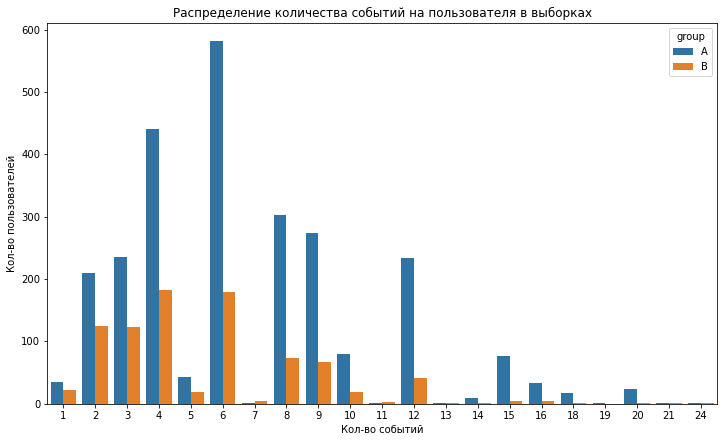

In [28]:
plt.figure(figsize=(12, 7))
ax = df_events.groupby(['event_name','group']).agg({'user_id':'count'}).reset_index()
sns.barplot(x='event_name', y='user_id', hue='group', data=ax)
plt.title('Распределение количества событий на пользователя в выборках')
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во пользователей')
plt.show()

Количество событий на пользователя в выборках распредеделены схоже, а именно, в обеих группах преобладают пользователи со средним количеством 4 и 6 событий на пользователя. Провалы средних значений мы также видим в схожих местах. 

Из-за неравномерного разделения количества пользователей на группы, количество пользователей для каждого количества событий в группе А сильно больше.

In [29]:
sample_1 = df_events[df_events['group'] == 'A']['event_name']
sample_2 = df_events[df_events['group'] == 'B']['event_name']

alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    display('Разница между средними статистически значима')
else:
    display('Статистически значимая разница между средними отсутствует')

p-значение: 5.641372898119324e-22


'Разница между средними статистически значима'

### Число событий в выборках по дням

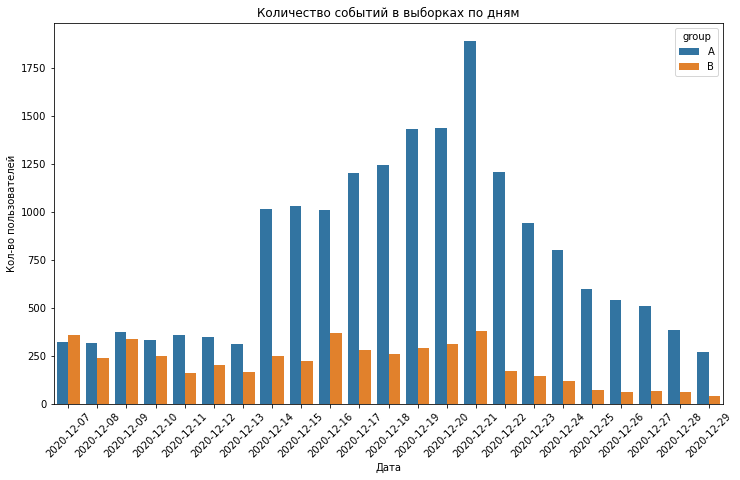

In [30]:
plt.figure(figsize=(12, 7))
ax = df_new_3.groupby(['event_dt', 'group'])['user_id'].count().reset_index()
sns.barplot(x='event_dt', y='user_id', hue='group', data=ax)
plt.title('Количество событий в выборках по дням')
plt.xlabel('Дата')
plt.ylabel('Кол-во пользователей')
plt.xticks(rotation=45) 
plt.show()

Число событий в выборках по дням распределено неравномерно. В группе А мы видим сильный всплекс 14 декабря 2020 г, а также 20 декабря 2020 г, возможно это вызвано тех.сбоем. Далее тренд на снижение в группах схож.

Интересно, что на дату начала маркетинговой активности  всплеска на графике нет.

### Конверсия

In [31]:
df_new_3['event_name'].unique()

array(['product_page', 'login', 'purchase', 'product_cart'], dtype=object)

In [32]:
events = df_new_3.groupby(['event_name', 'group']).nunique().reset_index()
events = events[['event_name', 'group', 'user_id']]
events['conversion_A'] = (events[events['group'] == 'A']['user_id'] / events[events['group'] == 'A']['user_id'].values[0] * 100).round(1)
events['conversion_B'] = (events[events['group'] == 'B']['user_id'] / events[events['group'] == 'B']['user_id'].values[0] * 100).round(1)
events

,event_name,group,user_id,conversion_A,conversion_B
0,login,A,2604,100.0,NaN
1,login,B,876,NaN,100.0
2,product_cart,A,782,30.0,NaN
3,product_cart,B,244,NaN,27.9
4,product_page,A,1685,64.7,NaN
5,product_page,B,493,NaN,56.3
6,purchase,A,833,32.0,NaN
7,purchase,B,249,NaN,28.4


In [33]:
# скорретируем порядок этапов покупки
new_index = [0, 1, 4, 5, 2, 3, 6, 7]
events = events.reindex(new_index) 

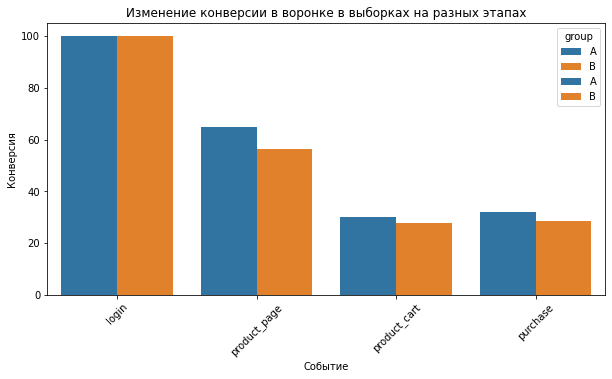

In [34]:
plt.figure(figsize=(10, 5))
ax = events
sns.barplot(x='event_name', y='conversion_A', hue='group', data=ax)
sns.barplot(x='event_name', y='conversion_B', hue='group', data=ax)
plt.title('Изменение конверсии в воронке в выборках на разных этапах')
plt.xlabel('Событие')
plt.ylabel('Конверсия')
plt.xticks(rotation=45) 
plt.show()

Конверсия в воронке в выборках на разных этапах имеет схожий характер. 

По ТЗ ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%.

Конверсия группы B на каждом этапе показывает ухудшение относительно группы А.

### Вывод

- Количество событий на пользователя в выборках распредеделены схоже, а именно, в обеих группах преобладают пользователи со средним количеством 4 и 6 событий на пользователя. Провалы средних значений мы также видим в схожих местах.
Из-за неравномерного разделения количества пользователей на группы, количество пользователей для каждого количества событий в группе А сильно больше.


- Число событий в выборках по дням распределено неравномерно. В группе А мы видим сильный всплекс 14 декабря 2020 г, а также 20 декабря 2020 г. Далее тренд на снижение в группах схож.
Интересно, что на дату начала маркетинговой активности  всплеска на графике нет. Необходимо проверить наличие технических сбоев в даты необосновано больших всплесков.


- Конверсия в воронке в выборках на разных этапах имеет схожий характер.
По ТЗ ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%.
Конверсия группы B на каждом этапе показывает ухудшение относительно группы А.

Прежде чем приступать к A/B-тестированию надо учесть следующие особенности:
- Количество пользователей на шаге "покупка" больше, чем на шаге "корзина" из-за того, что некоторые пользователи совершаю быструю покупку одного товара без перехода к корзине.
- Конверсия на каждом шаге показала ухудшение

## Результаты A/B-тестирования

Сформулируем гипотезы:
- Нулевая гипотеза: статистически значимой разницы между долями нет
- Альтернативная гипотеза: нет оснований считать, что статистически значимая разница между долями отсутствует

Для статической проверки равенства долей будем использовать z-test.

In [35]:
# посмотрим, сколько пользователей в каждой группе эксперимента
trials = df_new_3.groupby('group').agg({'user_id':'nunique'})

# построим воронку для каждой группы экперимента
funnel = df_new_3.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
display(trials)
display(funnel)

,user_id
group,
A,2604
B,877


group,A,B
event_name,,
login,2604,876
product_cart,782,244
product_page,1685,493
purchase,833,249


In [36]:
alpha = 0.05 # критический уровень статистической значимости принимаем 0.05
# создадим функцию для проверки гипотез
def z_test(success1, success2, trial1, trial2):
    p1 = success1/trial1 # отношение целевых действий ко всем 1 группы
    p2 = success2/trial2 # отношение целевых действий ко всем 2 группы
    p_combined = (success1+success2)/(trial1+trial2)
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trial1 + 1/trial2))
    distr = stats.norm(0,1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    #alpha = 0.05 критический уровень статистической значимости принимаем 0.05
    return p_value
    #if p_value < alpha:
        #return('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    #else:
        #return('Не получилось отвергнуть нулевую гипотезу: нет оснований считать группы разными') 

In [37]:
p_values = []

for groups in [['A', 'B']]:
    for event in funnel.index:
        p = z_test(funnel.loc[event, groups[0]], funnel.loc[event, groups[1]], trials.loc[groups[0]].values[0], trials.loc[groups[1]].values[0])
        p_values += [[groups[0], groups[1], event, p]]
p_values = pd.DataFrame(p_values, columns = ['A', 'B', 'event_name', 'p-value'])

# добавим колонку с проверкой
p_values['reject_h0'] = p_values['p-value'] < alpha

# посчитаем поправку Борферрони, чтобы скорректировать
# критический уровень статистической значимости
alpha = 0.05
alpha_b = alpha / p_values.shape[0] # делим на число экспериментов

p_values['reject_h0_b'] = p_values['p-value'] < alpha_b
p_values

,A,B,event_name,p-value,reject_h0,reject_h0_b
0,A,B,login,0.084818,False,False
1,A,B,product_cart,0.214692,False,False
2,A,B,product_page,0.000007,True,True
3,A,B,purchase,0.046525,True,False


Получили, что во всех случаях, как с поправкой, так и без результат одинаковый.

Отвергнуть нулевую гипотезу можем только при переходе на страницу продукта, значит, на этом этапе нет оснований считать, что статистически значимая разница между долями отсутствует. 
На других этапах - статистически значимой разницы между долями нет.

## Выводы

На этапе исследовательского анализа было определено, что конверсия на каждом шаге показала ухудшение.

На этапе оценки результатов A/B-тестирования мы получили, что статистически значимая разница между долями есть только на этапе перехода на страницу продукта.

Но какие-либо оценки по данным результатам делать некорректно, т.к. тест не корректен из-за следующих несоотвестсвий ТЗ, которые в том числе противоречат базовым принципам проведения A/B-текстирования:

1. По ТЗ нам для теста необходимы действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года, а мы имеем только с 7 по 30 декабря 2020 года.

2. Тест необходимо было запустить на новых пользователей только из региона EU, а тест был запущен еще и на 3 других регоиона.

3. Период проведения теста в рассматриваемом регионе EU пересекается с 1 маркетинговой активностью, что может сильно искажать поведение пользователей.

4. Тест целиком проведен в преддверии Нового года, в такие периоды поьзователи ведут себя аномально, данные об их действиях не подходят для анализа.

5. Пользователи между группами распределены неравномерно. В процентном соотношении группа А состаляет 74,8%, группа B 25,2%. Для для корректного А-B теста необходимо соотношение 50/50 %.

6. Аудитория состваляет 8,2% новых пользователей из региона EU вместо необходимых 15%.

7. Количество участников теста 3481 вместо необходимых 6000.

Рекомендуется переделать сбор данных с учетом проверки наличия технических сбоев и соответсвия всех пунктов ТЗ, после этого будет возможно проведение корректного анализа и формулировка выводов.